In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")

import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 471.23it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8024.30it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
import torch
import torch.nn as nn

class NTKNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NTKNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def ntk_kernel(x, y):
    n = x.shape[0]
    x = x.reshape(n, -1)
    y = y.reshape(n, -1)
    dot_product = torch.matmul(x, y.t())
    return torch.sqrt(torch.tensor(n, dtype=torch.float32)) * torch.erf(dot_product / torch.sqrt(torch.tensor(2 * n, dtype=torch.float32)))


def train_ntk_net(X, Y, epochs, lr):
    net = NTKNet(Y.shape[1], 512, X.shape[1]) # modify input and output sizes
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    for i in range(epochs):
        optimizer.zero_grad()
        y_trans = net(Y) # map Y to X's space
        loss = torch.abs(ntk_kernel(y_trans, X)).mean() # compute NTK kernel between mapped output and X
        loss.backward()
        optimizer.step()
        print(f"Epoch {i+1}/{epochs}, loss={loss.item():.4f}")
        
    return net



In [3]:
X = torch.Tensor(ref_train_data)
Y = torch.Tensor(tar_train_data)
epochs = 100
lr = 1e-3

net = train_ntk_net(X, Y, epochs, lr)

Epoch 1/100, loss=2.7540
Epoch 2/100, loss=34.2398
Epoch 3/100, loss=13.8606
Epoch 4/100, loss=3.5722
Epoch 5/100, loss=0.4024
Epoch 6/100, loss=1.0315
Epoch 7/100, loss=0.3540
Epoch 8/100, loss=1.1203
Epoch 9/100, loss=0.3814
Epoch 10/100, loss=0.8834
Epoch 11/100, loss=0.8472
Epoch 12/100, loss=0.3378
Epoch 13/100, loss=0.5767
Epoch 14/100, loss=0.5171
Epoch 15/100, loss=0.2737
Epoch 16/100, loss=0.3273
Epoch 17/100, loss=0.3617
Epoch 18/100, loss=0.2920
Epoch 19/100, loss=0.2301
Epoch 20/100, loss=0.2314
Epoch 21/100, loss=0.2482
Epoch 22/100, loss=0.2179
Epoch 23/100, loss=0.1870
Epoch 24/100, loss=0.2007
Epoch 25/100, loss=0.2044
Epoch 26/100, loss=0.1773
Epoch 27/100, loss=0.1750
Epoch 28/100, loss=0.1841
Epoch 29/100, loss=0.1751
Epoch 30/100, loss=0.1620
Epoch 31/100, loss=0.1625
Epoch 32/100, loss=0.1659
Epoch 33/100, loss=0.1609
Epoch 34/100, loss=0.1537
Epoch 35/100, loss=0.1530
Epoch 36/100, loss=0.1557
Epoch 37/100, loss=0.1542
Epoch 38/100, loss=0.1491
Epoch 39/100, loss=

In [4]:
T_trans = net(Y)

In [5]:
T_trans.shape


torch.Size([50000, 512])

In [16]:
ref_train_data

array([[0.        , 0.        , 1.3862395 , ..., 2.01611   , 0.6060404 ,
        0.4670472 ],
       [2.3884826 , 1.8559968 , 0.6663851 , ..., 0.6170911 , 2.1145046 ,
        1.7129223 ],
       [1.6156454 , 2.0472403 , 0.9266379 , ..., 0.25885504, 1.1148586 ,
        1.2194152 ],
       ...,
       [2.3992484 , 2.402385  , 0.5422969 , ..., 0.09138229, 0.8866464 ,
        1.4071962 ],
       [1.6172862 , 0.22004734, 1.036005  , ..., 2.0317147 , 0.6698662 ,
        1.9716433 ],
       [0.8757368 , 0.45541143, 0.51799047, ..., 0.16303115, 0.88168585,
        2.3847365 ]], dtype=float32)

In [14]:
T_trans* (-100)

tensor([[1.2718, 3.6957, 1.3425,  ..., 1.3518, 0.9676, 2.8316],
        [0.9404, 3.6996, 1.3147,  ..., 1.6838, 0.4359, 2.6726],
        [0.8701, 3.4018, 0.9563,  ..., 1.3823, 0.9435, 2.9047],
        ...,
        [0.8736, 3.4145, 0.9670,  ..., 1.3857, 0.9569, 2.9223],
        [0.8480, 3.4983, 1.0779,  ..., 1.5497, 0.5984, 2.7110],
        [0.7828, 3.5969, 1.0981,  ..., 1.5744, 0.8862, 3.0417]],
       grad_fn=<MulBackward0>)

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7338.81it/s]


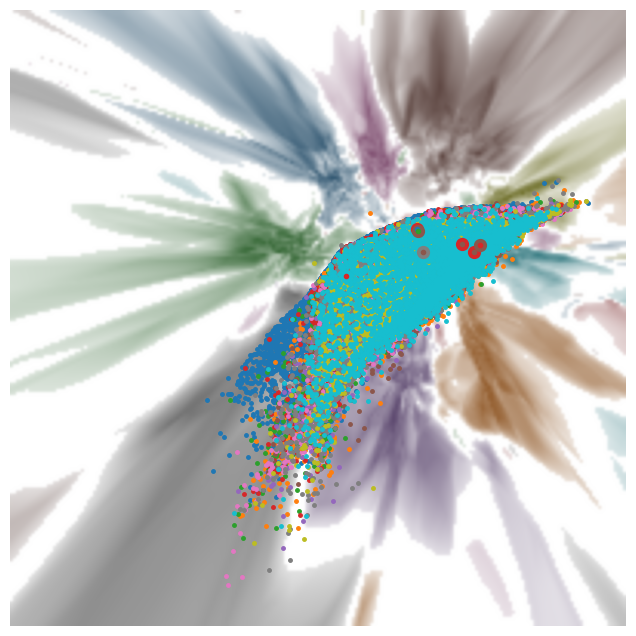

In [17]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot((T_trans* (-1000)).detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8232.58it/s]


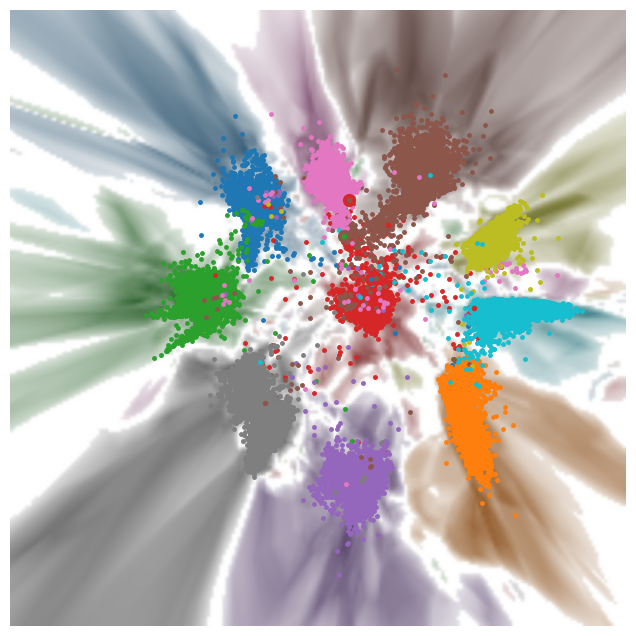

In [8]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))